# DataOrtho Modeling notebook

This notebook aims for the detection of anatomical landmarks on 3 different subsets: Axial, Sagittal and Dynamic


In [1]:
import os
import pandas as pd
import numpy as np
import ast
import nibabel as nib
import math
import datetime

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
import tensorflow_addons as tfa 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import  ModelCheckpoint,TensorBoard, EarlyStopping # ,LearningRateScheduler - estou a usar um dinâmico
from tensorflow.keras.metrics import Precision, Recall
#tf.config.run_functions_eagerly(True)

gpus = tf.config.list_physical_devices('GPU')
print(tf.__version__)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        print('GPU devices: ',gpus)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

else:
    print("No GPU available.")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)


2023-11-13 01:04:05.205036: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-11-13 01:04:05.245055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.71GHz coreCount: 80 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 849.46GiB/s
2023-11-13 01:04:05.245912: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-13 01:04:05.262330: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-13 01:04:05.274106: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-11-13 01:04:05.277017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcur

2.2.0
GPU devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1


2023-11-13 01:04:07.340969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.71GHz coreCount: 80 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 849.46GiB/s
2023-11-13 01:04:07.341040: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-13 01:04:07.341050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-13 01:04:07.341058: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-11-13 01:04:07.341066: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-11-13 01:04:07.341073: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library lib

### Vars and Paths

In [2]:
# Vars
LANDMARKS_SUBSET = {'DATASET_AXIAL':11, 'DATASET_SAGITTAL':7,'DATASET_DYNAMIC':18}

# Paths
resampled_dir  = '/home/birdlab/Desktop/dataOrtho_Edu/DataOrtho Resampled'
logs_dir = 'logs/' 

ata_dir = resampled_dir
fold_idx = 0
n_folds = 4
params = {'augment':True,
          'mode': tf.estimator.ModeKeys.TRAIN, 
          'subset':'DATASET_AXIAL',
          'mean':0.0,
          'stddev':0.01, 
          'interpolation':'Linear Interpolation',
          'normalization': 'batchnorm',
          'total_train_samples':0, # value attributed in dataset_split
          'total_val_samples':0,   # value attributed in dataset_split
          'lr': 0.0001,
          }
batch_size = 2
seed = 42 # check our context
xshape =  {'DATASET_AXIAL': (30,320, 320,1), 'DATASET_SAGITTAL': (25,320, 320,1),'DATASET_DYNAMIC': (_, _, _,1)}
yshape = {'DATASET_AXIAL': (30,320, 320,12), 'DATASET_SAGITTAL': (25,320, 320,8),'DATASET_DYNAMIC': (_, _, _, 19)}
input_shape={'DATASET_AXIAL': (30,320, 320,1), 'DATASET_SAGITTAL': (320, 320, 25,1),'DATASET_DYNAMIC': (_, _, _)} #change

### Help Functions

In [4]:
# not needed in ubuntu
def refactor_path(path_example):
    return path_example.replace("\\", "/")

In [5]:
#---------- 2D Visualization ----------#
# visualize mask only
def visualize_mask_of_sequence(mask,center,sigma=5):        
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='hot')
    plt.colorbar(label='Intensity')
    plt.title(f"Gaussian Mask (Center: {center}, Sigma: {sigma})")
    plt.show()
    
# visualize mri volume
def visualize_montage_mri(mri_volume, start_slice,end_slice, step=1):
    fig, axarr = plt.subplots(1, (end_slice - start_slice) // step, figsize=(15, 5))
    for i, idx in enumerate(range(start_slice, end_slice, step)):
        axarr[i].imshow(mri_volume[:,:,idx], cmap='gray')
        axarr[i].axis('off')
        axarr[i].set_title(f'Slice: {idx}')
    plt.tight_layout()
    plt.show()

#---------- 4D (channels dimension) Visualization ----------#
def plot_3d_gaussian(heatmap, threshold=0.01):
    """
    - threshold: Minimum intensity value to consider for plotting.
    """
    z, x, y = heatmap.shape
    X, Y, Z = np.mgrid[0:z, 0:x, 0:y]
    # Mask out values below the threshold
    mask = heatmap > threshold
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Y[mask], Z[mask], X[mask], c=heatmap[mask], cmap='jet', marker='o', s=5)

    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Gaussian Heatmap')
    plt.show()
    
def visualize_montage_mri_4D_channel(mri_volume,heatmaps_masks,channel, start_slice, end_slice, step=1):
    num_landmarks = heatmaps_masks.shape[-1] 
    
    fig, axarr = plt.subplots(1, (end_slice - start_slice) // step, figsize=(20, 5*num_landmarks))
    
    max_intensity_idx = np.unravel_index(np.argmax(heatmaps_masks[..., channel]), heatmaps_masks[..., channel].shape)
    print(f"Channel {channel} has maximum intensity at slice: {max_intensity_idx[2]}")

    for i, idx in enumerate(range(start_slice, end_slice, step)):
        axarr[i].imshow(mri_volume[:, :, idx], cmap='gray')  # MRI in grayscale
        axarr[i].imshow(heatmaps_masks[:, :, idx, channel], cmap='jet', alpha=0.5)  # specific landmark heatmap overlay
        axarr[i].axis('off')
        if i == 0:
            if channel == num_landmarks - 1:
                axarr[i].set_ylabel(f'Background')
            else:
                axarr[i].set_ylabel(f'Landmark {channel + 1}')
            
        axarr[i].set_title(f'Slice: {idx}')
        
    plt.tight_layout()
    plt.show()
    
def visualize_specific_slice_4Dmask(slice_idx,channel,mri_volume, heatmaps_channel):
    fig, axarr = plt.subplots(1, figsize=(16, 8))
    axarr.imshow(mri_volume[:,:,slice_idx],cmap='gray')
    axarr.imshow(heatmaps_channel[:, :, slice_idx, channel], cmap='jet', alpha=0.5)
    axarr.set_title(f'Slice: {slice_idx}')
    plt.show()

## Data Augmentation procedures

### 3D procedures from Architecture code obtained

#### Class of Transformations(inputs):
- PadXYZ
- CenterCrop(input_shape)
- RandomCrop3D(input_shape)
- NormalizeImages
- Cast(dtype=tf.float32)
- RandomHorizontalFlip 
- RandomVerticalFlip(threshold) (not to use)
- RandomGammaCorrection(gamma_range,keep_stats,threshold,epsilon)
- RandomBrightnessCorrection(alpha, threshold, per_channel)
- OneHotLabels(n_classes=LANDMARKS_SUBSET[subet])

USED:
- RandomRotate()
- RandomHorizontalFlip() 
- RandomTranslate(threshold) : 2D only
- Blur
- Noising


TODO:
- Zoom3D
- Shrink (?)

#### 3D function of Data Augmentation

Random Horizontal Flip 3D - **Validated**
- Axial - tf.image.flip_up_down

In [6]:
# change for type of subset used
def random_horizontal_flip(samples, labels, threshold=0.4):
    h_flip = tf.random.uniform([]) > threshold # type: ignore
    def hflip_volume(volume):
        return tf.image.flip_up_down(volume)

    samples = tf.cond(h_flip, lambda: hflip_volume(samples), lambda: samples)
    labels = tf.cond(h_flip, lambda: hflip_volume(labels), lambda: labels)
    return samples, labels

Random Rotate 3D - **Validated**

In [7]:
def random_rotate_3d(samples,labels,n_channels_samples,n_channels_labels,angle_range=(-5,5)):
    angle = tf.random.uniform([], minval=angle_range[0], maxval=angle_range[1])
    perform_augmentation = tf.random.uniform([]) > 0.4 # type: ignore
    samples = tf.cond(perform_augmentation, lambda: rotate_volume(samples, angle,n_channels_samples), lambda: samples)
    labels = tf.cond(perform_augmentation, lambda: rotate_volume(labels, angle,n_channels_labels), lambda: labels)
    return samples, labels


def rotate_volume(volume,angle,n_channels):
    def rotate_slice(slice):
        # ensure the number of channels is known
        # angle comes from higher lvl fnction
        rotated_channels = [tfa.image.rotate(slice[:, :, c], angle) for c in range(n_channels)]
        return tf.stack(rotated_channels, axis=-1)
    # Apply the rotation to each slice in the volume or mask
    rotated_volume = tf.map_fn(rotate_slice, volume, dtype=volume.dtype)
    return rotated_volume


Random Translate 3D - **Validated**

In [8]:
def random_translate_3d(samples, labels,n_slices,n_channels_samples,n_channels_labels, threshold=10):
    perform_augmentation = tf.random.uniform([]) > 0.4 # type: ignore
    translations = tf.random.uniform([2], minval=-threshold, maxval=threshold)

    samples = tf.cond(perform_augmentation, lambda: translate_volume(samples, translations,n_slices,n_channels_samples), lambda: samples) 
    labels = tf.cond(perform_augmentation, lambda: translate_volume(labels, translations,n_slices,n_channels_labels), lambda: labels)
    return samples, labels


def translate_volume(volume, translations,n_slices, n_channels):
    # We will collect the translated slices in this list.
    translated_slices = []

    # Loop over the depth dimension and translate each 2D slice.
    for i in range(n_slices):
        if n_channels == 1:
            # Translate the 2D slice and keep the channel dimension as the last dimension.
            slice_2d = volume[:, :, i, 0]  # Extract the 2D slice.
            translated_slice = tfa.image.translate(slice_2d, translations)
            translated_slice = tf.expand_dims(translated_slice, axis=-1)  # Add the channel dimension back.
        else:
            # Translate the 2D slice for each channel.
            slice_3d = volume[:, :, i, :]  # Extract the 3D slice (height, width, channels).
            translated_slice = [tfa.image.translate(slice_3d[:, :, c], translations) for c in range(n_channels)]
            translated_slice = tf.stack(translated_slice, axis=-1)

        # append the translated slice to the list.
        translated_slices.append(translated_slice)

    # stack the translated slices along the depth dimension.
    translated_volume = tf.stack(translated_slices, axis=2)
    
    return translated_volume

Zoom 3D - **Not Validated**

In [9]:
def zoom_3d(samples, labels, xshape, yshape, zoom_range=(0.8, 1.6)):
    zoom_factor = tf.random.uniform([], minval=zoom_range[0], maxval=zoom_range[1])

    # Define the zoom function for a single 2D slice
    def zoom_slice(slice_2d, zoom_factor, output_size):
        # Add a channel dimension to slice_2d if it doesn't have it
        if len(slice_2d.shape) == 2:
            slice_2d = tf.expand_dims(slice_2d, axis=-1)
        
        new_size = tf.cast(tf.cast(tf.shape(slice_2d)[:2], tf.float32) * zoom_factor, tf.int32)
        resized_slice = tf.image.resize(slice_2d, new_size)
        # Resize back to the output size and remove the added channel dimension if it was not originally present
        resized_slice = tf.image.resize(resized_slice, output_size)
        if resized_slice.shape[-1] == 1:
            resized_slice = tf.squeeze(resized_slice, axis=-1)
        return resized_slice

    # Apply the zoom to each slice for samples
    zoomed_samples = tf.map_fn(
        lambda slc: zoom_slice(slc, zoom_factor, xshape[:2]), 
        samples, 
        dtype=samples.dtype
    )

    # Apply the zoom to each slice for labels, handling each channel separately
    if labels is not None:
        def zoom_label_slices(label_3d):
            return tf.map_fn(
                lambda slc: zoom_slice(slc, zoom_factor, yshape[:2]), 
                label_3d, 
                dtype=labels.dtype
            )
        zoomed_labels = tf.map_fn(
            zoom_label_slices, 
            labels, 
            dtype=labels.dtype
        )

    # Set the shapes to match the target shapes
    zoomed_samples.set_shape(xshape)
    if labels is not None:
        zoomed_labels.set_shape(yshape)

    return zoomed_samples, zoomed_labels

Blur and Noising - **Validated**

In [25]:
def blur(samples, labels, sigma=2.0):
    def blur_slice(slice):
        return tfa.image.gaussian_filter2d(slice, sigma=sigma)
    
    perform_blurring = tf.random.uniform([]) < 0.3 # type: ignore
    blurred_samples = tf.cond(perform_blurring,
                              lambda: tf.map_fn(blur_slice, samples, dtype=samples.dtype),
                              lambda: samples)
    return blurred_samples, labels
    #blurred_samples = tf.map_fn(lambda slice: tfa.image.gaussian_filter2d(slice, sigma=sigma), samples, dtype=samples.dtype)
    #return blurred_samples, labels

def noising(samples, labels, mean=0.0, stddev=0.01):
    perform_noising = tf.random.uniform([]) < 0.3 # type: ignore
    noise = tf.random.normal(shape=tf.shape(samples), mean=mean, stddev=stddev)
    noised_samples = tf.cond(perform_noising,
                            lambda: samples + noise,
                            lambda: samples)
    return noised_samples, labels

Main Augmentation function

In [9]:
def process_augmentation(samples,labels):
    samples,labels = random_rotate_3d(samples,labels,xshape[params['subset']][-1],yshape[params['subset']][-1])
    samples, labels = random_horizontal_flip(samples, labels)
    #samples, labels = random_translate_3d(samples, labels,xshape[params['subset']][2],xshape[params['subset']][-1],yshape[params['subset']][-1])
    #samples, labels = zoom_3d(samples, labels) not completed
    #samples, labels = blur(samples, labels)
    samples, labels = noising(samples, labels)
    return samples, labels

## Data Input

### Landmark Classes

In [10]:
landmarkClasses = { 'DATASET_AXIAL':
                       {0:'A0',
                        1:'A1', 
                        2:'A2', 
                        3:'A3', 
                        4:'A4', 
                        5:'A5', 
                        6:'A6', 
                        7:'A7', 
                        8:'A8', 
                        9:'A9', 
                        10:'A10', 
                        11:'AB'},
                    'DATASET_SAGITTAL':
                       {0:'S0',
                        1:'S1', 
                        2:'S2', 
                        3:'S3', 
                        4:'S4', 
                        5:'S5', 
                        6:'S6', 
                        7:'SB' },
                    'DATASET_DYNAMIC':
                       {0:'D0',
                        1:'D1', 
                        2:'D2', 
                        3:'D3', 
                        4:'D4', 
                        5:'D5', 
                        6:'D6', 
                        7:'D7', 
                        8:'D8', 
                        9:'D9', 
                        10:'D10', 
                        11:'D11',
                        12:'D12', 
                        13:'D13', 
                        14:'D14', 
                        15:'D15', 
                        16:'D16', 
                        17:'D17', 
                        18:'DB'}}

### Normalization
 - mean and standard deviation calculation for normalization.
 - type 0 normalization with min and max
 - type 1 or else for normalization with mean and stddev

In [11]:
def calculate_normalization_params(volume_paths,norm_type=0):    
    if norm_type==0: 
        min_vals = []
        max_vals = []
        
        # Calculate min and max for each volume and append to respective lists
        for path in volume_paths:
            volume = nib.load(path).get_fdata().astype(np.float32)
            min_vals.append(np.min(volume))
            max_vals.append(np.max(volume))
        
        # Get the global min and max across all volumes
        global_min = np.min(min_vals)
        global_max = np.max(max_vals)
        return global_min, global_max
    else:
        all_volumes = [nib.load(path).get_fdata().astype(np.float32) for path in volume_paths]
        volumes_concat = np.concatenate(all_volumes, axis=-1)
        mean = np.mean(volumes_concat)
        std = np.std(volumes_concat)
        return mean, std
    
# Apply z-score normalization to the volume.
def normalize_volume(volume, mean, std):
    return (volume - mean) / std

# Apply min-max normalization to the volume.
def normalize_volume_minmax(volume,min_val,max_val):
    return (volume - min_val) / (max_val - min_val)


### Input and Load

Each Test subset individuals:


In [12]:
test_subjects = {'DATASET_AXIAL': [5, 20, 23, 35, 47, 56, 66, 72, 77, 82, 12, 13, 39, 44, 46, 51, 64, 70] ,
                 'DATASET_SAGITTAL': [5, 20, 23, 34, 45, 54, 64, 70, 75, 81, 12, 13, 38, 42, 44, 49, 62, 68],
                 'DATASET_DYNAMIC': [5, 20, 23, 33, 43, 51, 61, 67, 71, 76, 12, 13, 37, 41, 42, 47, 59, 65]}

Make sure that the shuffle, batch, and prefetch methods are called in the correct order and with the correct parameters to ensure efficient loading and training.


**zip(*iterable)**: When used with the asterisk operator *, it unpacks a list or tuple of iterables, effectively doing the reverse operation of zip. It's often used to unzip a list of pairs into two lists or tuples.

#### Dataset Construction (Explanation incomplete)

- Load and normalize paths to NIfTI data
- Cross Validation

In [13]:
def load_and_normalize_nii_data(volume_path,mask_path, value1, value2,norm_type):
    volume_path = volume_path.decode('utf-8') if isinstance(volume_path, bytes) else volume_path
    mask_path = mask_path.decode('utf-8') if isinstance(mask_path, bytes) else mask_path

    volume = nib.load(volume_path).get_fdata().astype(np.float32)
    mask = nib.load(mask_path).get_fdata().astype(np.float32)
    if norm_type == 0:
        volume = normalize_volume_minmax(volume, value1, value2)
        
    else:
        volume = normalize_volume(volume, value1, value2)
        
    volume = volume.reshape(volume.shape + (1,))

    volume = np.transpose(volume, (2, 0, 1, 3))
    mask = np.transpose(mask, (2, 0, 1, 3))

    volume_tensor = tf.convert_to_tensor(volume, dtype=tf.float32)
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
    return volume_tensor, mask_tensor

def parse_test(data_dir,test_subjects):
     volume_files = []
     masks_files = []
     resampled_path_volume = os.path.join(data_dir, 'Volumes')
     resampled_path_masks = os.path.join(data_dir, 'Masks')
     
     for individual in os.listdir(resampled_path_volume):
          if int(individual) in test_subjects:
               individual_resampled_volumes = os.path.join(resampled_path_volume, individual)
               individual_resampled_masks = os.path.join(resampled_path_masks, individual)
               for knee in os.listdir(individual_resampled_volumes):
                    knee_resampled_volumes = os.path.join(individual_resampled_volumes, knee)
                    knee_resampled_masks = os.path.join(individual_resampled_masks, knee)
                    for sequence in os.listdir(knee_resampled_volumes):
                         sequence_resampled_volume = os.path.join(knee_resampled_volumes, sequence)
                         sequence_resampled_masks = os.path.join(knee_resampled_masks, sequence)
                         for file in os.listdir(sequence_resampled_volume):
                              volume_file_path = os.path.join(sequence_resampled_volume, file)
                              mask_file_path = os.path.join(sequence_resampled_masks, sequence + "_mask.nii.gz")
                              volume_files.append(volume_file_path)
                              masks_files.append(mask_file_path)
                    
     return list(zip(volume_files, masks_files))

# List of tuples, where each tuple contains the path to a volume file and its corresponding mask file.
def create_subject_paths(subset_dir,test_subjects):
    volume_files = []
    masks_files = []
    resampled_path_volume = os.path.join(subset_dir, 'Volumes')
    resampled_path_masks = os.path.join(subset_dir, 'Masks')

    for individual in os.listdir(resampled_path_volume):
        if int(individual) not in test_subjects:
            individual_resampled_volumes = os.path.join(resampled_path_volume, individual)
            individual_resampled_masks = os.path.join(resampled_path_masks, individual)
            for knee in os.listdir(individual_resampled_volumes):
                knee_resampled_volumes = os.path.join(individual_resampled_volumes, knee)
                knee_resampled_masks = os.path.join(individual_resampled_masks, knee)
                for sequence in os.listdir(knee_resampled_volumes):
                    sequence_resampled_volume = os.path.join(knee_resampled_volumes, sequence)
                    sequence_resampled_masks = os.path.join(knee_resampled_masks, sequence)
                    for file in os.listdir(sequence_resampled_volume):
                        volume_file_path = os.path.join(sequence_resampled_volume, file)
                        mask_file_path = os.path.join(sequence_resampled_masks, sequence + "_mask.nii.gz")
                        volume_files.append(volume_file_path)
                        masks_files.append(mask_file_path)   
                    
    return list(zip(volume_files, masks_files))


def load_dataset(subject_paths,normalization_params,norm_type = 0):
    volume_files, masks_files = map(list,zip(*subject_paths))
    # Reformat all paths in the list
    
    reformatted_volume_paths = [path.replace("\\", "/") for path in volume_files]
    reformatted_masks_paths = [path.replace("\\", "/") for path in masks_files]
    
    # volume_files, masks_files = zip(*subject_paths)
    # create a dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices((reformatted_volume_paths, reformatted_masks_paths))
    if norm_type == 0:
        _min,_max = normalization_params
        # load the actual data using the load_nii_data function
        dataset = dataset.map(lambda volume_file, mask_file: tf.numpy_function(
                load_and_normalize_nii_data, [volume_file, mask_file,_min,_max,norm_type], [tf.float32, tf.float32]
        ))
        
    else:
        mean,std = normalization_params            
        dataset = dataset.map(lambda volume_file, mask_file: tf.numpy_function(
            load_and_normalize_nii_data, [volume_file, mask_file,mean,std,norm_type], [tf.float32, tf.float32]
        ))    
       
   
    # After loading and possibly normalizing, set the shapes
    volume_shape = xshape[params['subset']] # Replace with the actual shape of your volume
    mask_shape = yshape[params['subset']]   # Replace with the actual shape of your mask

    dataset = dataset.map(lambda volume, mask: (tf.ensure_shape(volume, volume_shape),
                                                tf.ensure_shape(mask, mask_shape)))
    return dataset

# Cross Validation function before train, val e test datasets created
def subset_cross_validation(subset_dir, test_subjects,fold_idx, n_folds):
    # get all subject paths
    subject_paths = create_subject_paths(subset_dir,test_subjects)
    # convert to numpy array for easy manipulation
    subject_paths_array = np.array(subject_paths)

    # perform cross-validation
    kf = KFold(n_splits=n_folds)
    folds = list(kf.split(subject_paths_array))
    
    # get the current fold data
    train_indices, val_indices = folds[fold_idx]
    train_paths = subject_paths_array[train_indices].tolist()
    val_paths = subject_paths_array[val_indices].tolist()
    
    # calculate normalization parameters for the current fold's training data
    train_volume_paths, _ = map(list,zip(*train_paths))

    normalization_params_train = calculate_normalization_params(train_volume_paths,0)

    return train_paths, val_paths, normalization_params_train


Functions responsible for the train, validation and test input dataset to the network

**.repeat()** transformation in your dataset pipeline, the dataset will produce elements indefinitely. If not, once you reach the end of the dataset, you'll need to re-initialize it to go through the data again.

In [14]:
def train_fn(subject_paths,normalization_params_train,norm_type,batch_size,seed,params):
        """ Create dataset for training """
        dataset = load_dataset(subject_paths,normalization_params_train,norm_type)
        # dataset_length = len(list(dataset))
        # assert dataset_length > 0, "Training data not found."
        dataset = dataset.cache()
        # dataset = dataset.cache()
        dataset = dataset.repeat() # will ensure that the dataset can be iterated over indefinitely.

        if params['augment']:
            dataset = dataset.map(
                map_func=lambda x, y: process_augmentation(x, y),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
        dataset = dataset.shuffle(100, seed)
        dataset = dataset.batch(batch_size,
                                drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        #print_dataset_shapes(dataset)
        return dataset

def val_fn(val_paths,normalization_params,batch_size):
    """ Create dataset for Validation """
    dataset = load_dataset(val_paths, normalization_params)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=False) # not
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # print_dataset_shapes(dataset)

    return dataset


def test_fn(test_paths,normalization_params,batch_size):
    """ Create dataset for Test"""
    dataset = load_dataset(test_paths, normalization_params)

    dataset = dataset.batch(batch_size=batch_size)
                            #drop_remainder=self.params.benchmark)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    #print_dataset_shapes(dataset)

    return dataset

def print_dataset_shapes(dataset):
    """ Prints the shapes of the dataset elements """
    for element_spec in dataset.element_spec:
        print(f"Shape of {element_spec.name}: {element_spec.shape}")

Function responsible for the division and creation for specific Subset data: train, test and validation data

In [15]:
def dataset_split(interpolation):
    data_dir = os.path.join(resampled_dir,interpolation,params['subset'])
    
    test_paths = parse_test(data_dir,test_subjects[params['subset']])
    # perform cross-validation on the paths that are valid for training,
    # subset_cross_validation must make sure that trains_paths and val_paths return without
    # any of the subject indicated on test_subjects list 
    train_paths, val_paths, normalization_params_train = subset_cross_validation(data_dir, test_subjects[params['subset']], fold_idx, n_folds) #separate norm_params training and validation
    
    print("Number of training paths:", len(train_paths))
    print("Number of validation paths:", len(val_paths))
    print("Number of test paths:", len(test_paths))
    print("Normalization parameters training:", normalization_params_train)
    
    params['total_train_samples'] = len(train_paths)
    params['total_val_samples'] =  len(val_paths)
    
    # create the train_ds input and tensorflow.python.data.ops.map_op._MapDataset Dataset
    train_d = train_fn(train_paths,normalization_params_train,0,batch_size,seed,params)
    
    val_ds = val_fn(val_paths,normalization_params_train,batch_size)
    
    test_ds = test_fn(test_paths,normalization_params_train,batch_size)
    
    return train_paths,train_d,val_ds, test_ds ,normalization_params_train
    

### Test data augmentation transforms on data

In [200]:
volume, masks = load_and_normalize_nii_data('/home/birdlab/Desktop/dataOrtho_Edu/DataOrtho Resampled/Linear Interpolation/DATASET_AXIAL/Volumes/37/RIGHT/AXIAL_DP_FS_MTC_DRT_7/AXIAL_DP_FS_MTC_DRT_7.nii.gz','/home/birdlab/Desktop/dataOrtho_Edu/DataOrtho Resampled/Linear Interpolation/DATASET_AXIAL/Masks/37/RIGHT/AXIAL_DP_FS_MTC_DRT_7/AXIAL_DP_FS_MTC_DRT_7_mask.nii.gz',0.0, 2898.0,0)
masks.shape

TensorShape([30, 320, 320, 12])

In [87]:
augmented_volume, augmented_mask = random_rotate_3d(volume,masks,1,12)

In [82]:
augmented_volume.shape

TensorShape([30, 320, 320, 1])

In [83]:
augmented_mask.shape

TensorShape([30, 320, 320, 12])

In [84]:
# Function to visualize a single slice
def visualize_slice(volume_slice, mask_slice=None, cmap='gray'):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(volume_slice, cmap=cmap)
    plt.title('Volume Slice')
    plt.axis('off')
    
    if mask_slice is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(mask_slice, cmap=cmap)
        plt.title('Mask Slice')
        plt.axis('off')
    
    plt.show()

In [78]:
slice_idx = 8 #volume_tensor.shape[2] // 2  # Get the middle slice index

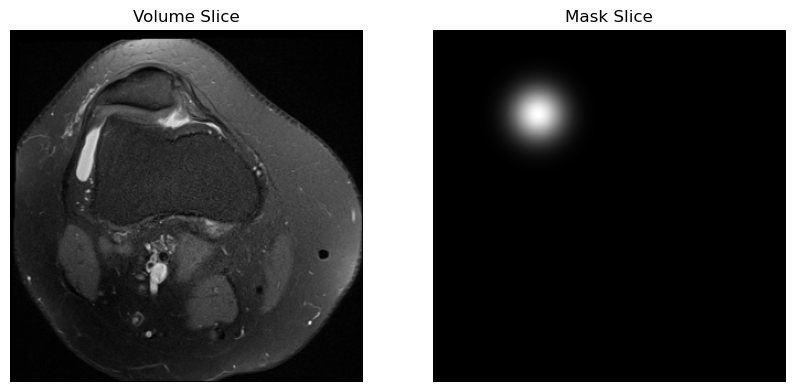

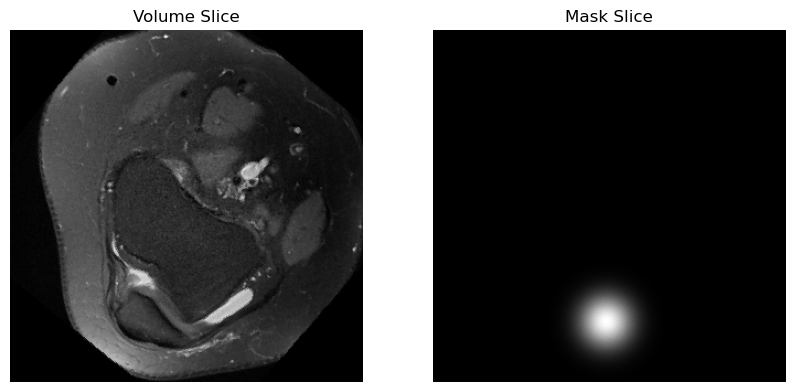

In [88]:
visualize_slice(volume[slice_idx, :, : , 0].numpy(), masks[slice_idx, :, : , 0].numpy()) # type: ignore
visualize_slice(augmented_volume[slice_idx, :, : , 0].numpy(), augmented_mask[slice_idx, :, : ,0].numpy()) # type: ignore

### Tensors full Dataset creation: Train, Validation, Test

dataset_split - 17s

train_paths for debug

In [18]:
# , train_ds, val_ds,test_ds, normalization_params_train
train_paths, train_ds, val_ds,test_ds, normalization_params_train = dataset_split('Linear Interpolation')

Number of training paths: 139
Number of validation paths: 47
Number of test paths: 48
Normalization parameters training: (0.0, 2898.0)


In [20]:
print(train_ds.element_spec)
print(val_ds.element_spec)
print(test_ds.element_spec)

(TensorSpec(shape=(8, 320, 320, 30, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 320, 320, 30, 12), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 320, 320, 30, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 320, 30, 12), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 320, 320, 30, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 320, 30, 12), dtype=tf.float32, name=None))


Last batching needed?

In [121]:
for volume, mask in train_ds.take(1):
    print(volume.shape)
    print(mask.shape)

(1, 320, 320, 30, 1)
(1, 320, 320, 30, 12)


#### Tf dataset creation step by step

In [67]:
volume_files, masks_files = map(list,zip(*train_paths))

In [68]:
print(len(volume_files), len(masks_files))

139 139


In [69]:
dataset = load_dataset(train_paths,normalization_params_train,0)

In [70]:
print_dataset_shapes(dataset)

Shape of None: (30, 320, 320, 1)
Shape of None: (30, 320, 320, 12)


In [71]:
dataset = dataset.cache()
dataset = dataset.shuffle(len(volume_files), seed)
dataset = dataset.repeat() # will ensure that the dataset can be iterated over indefinitely.

In [72]:
if params['augment']:
    dataset = dataset.map(
        map_func=lambda x, y: process_augmentation(x, y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

In [ ]:
dataset = dataset.batch(batch_size,
                        drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [32]:
print_dataset_shapes(dataset)

Shape of None: (8, 320, 320, 30, 1)
Shape of None: (8, 320, 320, 30, 12)


## Architecture

### Architecture Layers

#### Lower level methods:

convolution, normalization and activation methods:
more control of the architecture

In [18]:
def _normalization(inputs, name, mode):
    """ Choose a normalization layer

    :param inputs: Input node from the graph
    :param name: Name of layer
    :param mode: Estimator's execution mode
    :return: Normalized output
    """
    training = mode == tf.estimator.ModeKeys.TRAIN

    if name == 'instancenorm':
        gamma_initializer = tf.constant_initializer(1.0) # type: ignore
        return tf.contrib.layers.instance_norm( # type: ignore
            inputs,
            center=True,
            scale=True,
            epsilon=1e-6,
            param_initializers={'gamma': gamma_initializer},
            reuse=None,
            variables_collections=None,
            outputs_collections=None,
            trainable=True,
            data_format='NHWC',
            scope=None)

    if name == 'groupnorm':
        return tf.contrib.layers.group_norm(inputs=inputs, # type: ignore
                                            groups=16,
                                            channels_axis=-1,
                                            reduction_axes=(-4, -3, -2),
                                            activation_fn=None,
                                            trainable=True)

    if name == 'batchnorm':
        return tf.keras.layers.BatchNormalization(axis=-1,
                                                  trainable=True,
                                                  virtual_batch_size=None)(inputs, training=training)
    if name == 'none':
        return inputs

    raise ValueError('Invalid normalization layer')


def _activation(out, activation):
    """ Choose an activation layer

    :param out: Input node from the graph
    :param activation: Name of layer
    :return: Activation output
    """
    if activation == 'relu':
        return tf.nn.relu(out)
    if activation == 'leaky_relu':
        return tf.nn.leaky_relu(out, alpha=0.01)
    if activation == 'sigmoid':
        return tf.nn.sigmoid(out)
    if activation == 'softmax':
        return tf.nn.softmax(out, axis=-1)
    if activation == 'none':
        return out

    raise ValueError("Unknown activation {}".format(activation))

def convolution(inputs,  # pylint: disable=R0913
                out_channels,
                kernel_size=2,
                stride=1,
                mode=tf.estimator.ModeKeys.TRAIN,
                normalization='batchnorm',
                activation='leaky_relu',
                transpose=False):
    """ Create a convolution layer

    :param inputs: Input node from graph
    :param out_channels: Output number of channels
    :param kernel_size: Size of the kernel
    :param stride: Stride of the kernel
    :param mode: Estimator's execution mode
    :param normalization: Name of the normalization layer
    :param activation: Name of the activation layer
    :param transpose: Select between regular and transposed convolution
    :return: Convolution output
    """
    if transpose:
        conv = tf.keras.layers.Conv3DTranspose
    else:
        conv = tf.keras.layers.Conv3D
    regularizer = None  # tf.keras.regularizers.l2(1e-5)

    use_bias = normalization == "none"
    inputs = conv(filters=out_channels,
                  kernel_size=kernel_size,
                  strides=stride,
                  activation=None,
                  padding='same',
                  data_format='channels_last',
                  kernel_initializer=tf.compat.v1.glorot_uniform_initializer(), # type: ignore perhaps use HE
                  kernel_regularizer=regularizer,
                  bias_initializer=tf.zeros_initializer(), # type: ignore
                  bias_regularizer=regularizer,
                  use_bias=use_bias)(inputs)

    inputs = _normalization(inputs, normalization, mode)
    #print(' Convolution INPUTS SHAPE',inputs.shape)
    return _activation(inputs, activation)

#### Higher level

The key difference between using strided convolutions and MaxPooling for downsampling is that strided convolutions involve learnable parameters and can learn to downsample in a more data-driven manner, whereas MaxPooling is a fixed operation that simply takes the maximum value over the pooling window.

In [19]:
def input_block(inputs, out_channels, normalization, mode):
    """ Create the input block

    :param inputs: Input node from the graph
    :param out_channels: Number of output channels
    :param normalization:  Name of the normalization layer
    :param mode: Estimator's execution mode
    :return: Output from the input block
    """
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    return inputs

def dynamic_crop_and_concat(up_conv,skip_feature):
    print('Skip feature before crop :',up_conv.shape)

    crop_size = [(up_conv.shape[i+1] - skip_feature.shape[i+1]) // 2 for i in range(3)]
    additional_crop = [(up_conv.shape[i+1] - skip_feature.shape[i+1]) % 2 for i in range(3)]
    crop_size = [(crop_size[i], crop_size[i] + additional_crop[i]) for i in range(3)]
    
    # Concatenate along the feature axis
    cropped_up_conv = tf.keras.layers.Cropping3D(cropping=crop_size)(up_conv)
    print('INPUT SHAPE cropped to CONCATENATE:',cropped_up_conv.shape,'Skip feature to CONCATENATE:',skip_feature.shape)

    return tf.keras.layers.Concatenate(axis=-1)([cropped_up_conv, skip_feature])

def upsample_block(inputs, skip_connection, out_channels, normalization, mode):
    """ Create a block for upsampling

    :param inputs: Input node from the graph
    :param skip_connection: Choose whether or not to use skip connection
    :param out_channels: Number of output channels
    :param normalization: Name of the normalizaiton layer
    :param mode: Estimator's execution mode
    :return: Output from the upsample block
    """

    inputs = convolution(inputs, kernel_size=2, out_channels=out_channels, stride=2,
                         normalization='none', activation='none', transpose=True)
    
    # Use dynamic crop and concat
    inputs = dynamic_crop_and_concat(inputs, skip_connection)

    #inputs = tf.keras.layers.Concatenate(axis=-1)([inputs, skip_connection])
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    print('INPUT SHAPE after CONCATENATE:',inputs.shape)

    return inputs


def downsample_block(inputs, out_channels, normalization, mode):
    """ Create a downsample block

    :param inputs: Input node from the graph
    :param out_channels: Number of output channels
    :param normalization:  Name of the normalization layer
    :param mode: Estimator's execution mode
    :return: Output from the downsample block
    """   
    
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode, stride=2)
    return convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)

# Residual blocks
def downsample_Residual_block(inputs, out_channels, normalization, mode):
    """ Create a downsample Residual block, 
    :param inputs: Input node from the graph
    :param out_channels: Number of output channels
    :param normalization:  Name of the normalization layer
    :param mode: Estimator's execution mode
    :return: Output from the downsample block
    """

    # Convolutional path
    conv_path = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode, stride=2)
    conv_path = convolution(conv_path, out_channels=out_channels, normalization=normalization, mode=mode)
    
    output_shape = conv_path.shape.as_list()

    print('OUTPUT SHAPE after first convolution:', output_shape)
    # Residual path
    # modification adds a residual connection that includes a 1x1x1 convolution with a stride of 2 to downsample the input before adding 
    # it to the output of the convolutional layers within the block
    residual_path = convolution(inputs, out_channels=out_channels, kernel_size=1, stride=2,
                                normalization=normalization, mode=mode, activation='none')
    
    # Add the residual connection
    out = tf.keras.layers.Add()([conv_path, residual_path])
    out = _activation(out, 'leaky_relu')
    return out
    

def output_layer(inputs, out_channels, activation):
    """ Create the output layer

    :param inputs: Input node from the graph
    :param out_channels: Number of output channels
    :param activation:  Name of the activation layer
    :return: Output from the output block
    """
    return convolution(inputs, out_channels=out_channels, kernel_size=3, normalization='none', activation=activation)

### 3D U-Net Model

   Simple UNet3D build
    
        :param n_classes: Number of output channels
        :param mode: Estimator's execution mode
        :param normalization: Name of the normalization layer    
        :param features: Input features
        :return: Output of the graph
    

In [109]:
def unet3d(n_classes,mode,features,normalization='none'):

        skip_128 = input_block(inputs=features,
                               out_channels=32,
                               normalization=normalization,
                               mode=mode)

        skip_64 = downsample_block(inputs=skip_128,
                                   out_channels=64,
                                   normalization=normalization,
                                   mode=mode)

        skip_32 = downsample_block(inputs=skip_64,
                                   out_channels=128,
                                   normalization=normalization,
                                   mode=mode)

        skip_16 = downsample_block(inputs=skip_32,
                                   out_channels=256,
                                   normalization=normalization,
                                   mode=mode)

        skip_8 = downsample_block(inputs=skip_16,
                                  out_channels=320,
                                  normalization=normalization,
                                  mode=mode)

        out = downsample_block(inputs=skip_8,
                               out_channels=320,
                               normalization=normalization,
                               mode=mode)

        out = upsample_block(out, skip_8,
                             out_channels=320,
                             normalization=normalization,
                             mode=mode)

        out = upsample_block(out, skip_16,
                             out_channels=256,
                             normalization=normalization,
                             mode=mode)

        out = upsample_block(out, skip_32,
                             out_channels=128,
                             normalization=normalization,
                             mode=mode)

        out = upsample_block(out, skip_64,
                             out_channels=64,
                             normalization=normalization,
                             mode=mode)

        out = upsample_block(out, skip_128,
                             out_channels=32,
                             normalization=normalization,
                             mode=mode)

        return output_layer(out,
                            out_channels=n_classes,
                            activation='softmax')

- For the features (input volumes), you should have a 5D tensor with the shape 
**[batch_size, depth, height, width, channels]**. Since medical volumes are often single-channel (grayscale), this last dimension might be 1.

- For the labels (masks), if you're dealing with multi-class segmentation where each channel represents a different class, then you would indeed have a channels dimension. However, TensorFlow typically expects the channels to be the last dimension. So your masks should also be shaped as **[batch_size, depth, height, width, channels]**.

    ResNet (Residual Blocks) on U-Net build

In [20]:
def residual_unet3d(n_classes, mode, features, normalization='batchnorm'):
    skip_connections = []
    out_channels_sequence = [16,32, 64]

    # input block
    features = input_block(inputs=features,
                           out_channels=out_channels_sequence[0],
                           normalization=normalization,
                           mode=mode)
    skip_connections.append(features)
    
    # downsampling blocks
    for out_channels in out_channels_sequence[1:]:  # first one used on the input_block
        features = downsample_Residual_block(inputs=features,
                                             out_channels=out_channels,
                                             normalization=normalization,
                                             mode=mode)
        skip_connections.append(features)
    
    # Bottom layer
    out = downsample_block(inputs=features,
                           out_channels=320,
                           normalization=normalization,
                           mode=mode)
    
    # upsampling blocks
    for out_channels, skip_connection in zip(reversed(out_channels_sequence), reversed(skip_connections)):
        out = upsample_block(inputs=out,
                             skip_connection=skip_connection,
                             out_channels=out_channels,
                             normalization=normalization,
                             mode=mode)       
    # output layer
    out = output_layer(out, out_channels=n_classes, activation='softmax')
    return out

## Metrics

### Evaluation Metrics for Landmark Detection:

commonly used ones are:

- Mean Euclidean Distance: average Euclidean distance between the predicted and true landmark positions (idea of the accuracy of the landmark predictions).
- Detection Rate: The fraction of landmarks correctly detected within a certain tolerance range.
- Dice Similarity Coefficient: Commonly used for segmentation tasks, it measures the spatial overlap between predicted and ground truth landmarks.
- Mean Squared Error (MSE) between predicted and ground truth heatmaps can be used (Heatmap-based metrics).

In [22]:
def make_loss(params, y_true, y_pred):
    """ Factory method for loss functions

    :param params: Dict with additional parameters
    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :return: Loss
    """
    if params['loss'] == 'dice':
        return _dice(y_true, y_pred)
    if params['loss'] == 'ce':
        return _ce(y_true, y_pred)
    if params['loss'] == 'dice+ce':
        return tf.add(_ce(y_true, y_pred), _dice(y_true, y_pred), name="total_loss_ref")
    if params['loss'] == 'mse':
        return _mse(y_true, y_pred)

    raise ValueError('Unknown loss: {}'.format(params.loss))


def _ce(y_true, y_pred):
    """ Crossentropy

    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :return: loss
    """
    return tf.reduce_sum(
        tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tf.cast(y_true, tf.float32), y_pred), axis=[0, 1, 2, 3]),
        name='crossentropy_loss_ref')


def _dice(y_true, y_pred):
    """ Training dice

    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :return: loss
    """
    return tf.reduce_sum(dice_loss(predictions=y_pred, targets=y_true), name='dice_loss_ref')

def _mse(y_true, y_pred):
    """ Mean Squared Error loss.
    
    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :return: MSE loss.
    """
    return tf.reduce_mean(tf.square(y_true - y_pred))

def eval_dice(y_true, y_pred):
    """ Evaluation dice

    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :return: loss
    """
    return 1 - dice_loss(predictions=y_pred, targets=y_true)


def dice_loss(predictions,
              targets,
              squared_pred=False,
              smooth=1e-5,
              top_smooth=0.0):
    """ Dice

    :param predictions: Predicted labels
    :param targets: Ground truth labels
    :param squared_pred: Square the predicate
    :param smooth: Smooth term for denominator
    :param top_smooth: Smooth term for numerator
    :return: loss
    """
    is_channels_first = False

    n_len = len(predictions.get_shape())
    reduce_axis = list(range(2, n_len)) if is_channels_first else list(range(1, n_len - 1))
    intersection = tf.reduce_sum(targets * predictions, axis=reduce_axis)

    if squared_pred:
        targets = tf.square(targets)
        predictions = tf.square(predictions)

    y_true_o = tf.reduce_sum(targets, axis=reduce_axis)
    y_pred_o = tf.reduce_sum(predictions, axis=reduce_axis)

    denominator = y_true_o + y_pred_o

    dice = (2.0 * intersection + top_smooth) / (denominator + smooth)

    return 1 - tf.reduce_mean(dice, axis=0)


def total_dice(predictions,
               targets,
               smooth=1e-5,
               top_smooth=0.0):
    """ Total Dice

    :param predictions: Predicted labels
    :param targets: Ground truth labels
    :param smooth: Smooth term for denominator
    :param top_smooth: Smooth term for numerator
    :return: loss
    """
    n_len = len(predictions.get_shape())
    reduce_axis = list(range(1, n_len-1))
    targets = tf.reduce_sum(targets, axis=-1)
    predictions = tf.reduce_sum(predictions, axis=-1)
    intersection = tf.reduce_sum(targets * predictions, axis=reduce_axis)

    y_true_o = tf.reduce_sum(targets, axis=reduce_axis)
    y_pred_o = tf.reduce_sum(predictions, axis=reduce_axis)

    denominator = y_true_o + y_pred_o

    return tf.reduce_mean((2.0 * intersection + top_smooth) / (denominator + smooth))

## Callback Methods

- Avoiding overfitting
- early stopping when validation accuracy no longer drops for a number of epochs
- record session to be available on tensorboard.

cd into log directory and <: tensorboard --logdir logs/path

In [23]:
def prepareCallbacks(path,log_and_model_path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_accuracy',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    return file_path, [checkpointer, earlyStopper, tbCallBack] 

# Approach 1 - Axial Subset - residual_unet3d

## Data input

In [26]:
train_paths ,train_axial, val_axial, test_axial, norm_params = dataset_split(params['interpolation']) 

Number of training paths: 139
Number of validation paths: 47
Number of test paths: 48
Normalization parameters training: (0.0, 2898.0)


In [24]:
print(train_axial.element_spec)

(TensorSpec(shape=(2, 30, 320, 320, 1), dtype=tf.float32, name=None), TensorSpec(shape=(2, 30, 320, 320, 12), dtype=tf.float32, name=None))


## Training 

In [38]:
logs_axial = refactor_path(os.path.join(logs_dir,params['interpolation'],params['subset']))

In [26]:
# Define a unique path for this training session
training_session_path = 'residual_unet3d_{}'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S"))

In [27]:
file_path, callbacks_list = prepareCallbacks(training_session_path, logs_axial)

2023-11-12 16:42:28.997324: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2023-11-12 16:42:28.997846: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1363] Profiler found 1 GPUs
2023-11-12 16:42:29.002744: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcupti.so.10.1
2023-11-12 16:42:29.103834: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-11-12 16:42:29.104972: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-11-12 16:42:29.106245: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, C

In [30]:
# Initial input features
features = tf.keras.layers.Input(shape=input_shape[params['subset']])

In [31]:
print('residual_unet3d input:',yshape[params['subset']][-1],params['mode'],features)

residual_unet3d input: 12 train Tensor("input_2:0", shape=(None, 30, 320, 320, 1), dtype=float32)


In [32]:
# ,normalization='batchnorm' ?
output = residual_unet3d(yshape[params['subset']][-1],params['mode'],features,params['normalization'])

OUTPUT SHAPE after first convolution: [None, 15, 160, 160, 32]
OUTPUT SHAPE after first convolution: [None, 8, 80, 80, 64]
Skip feature before crop : (None, 8, 80, 80, 64)
INPUT SHAPE cropped to CONCATENATE: (None, 8, 80, 80, 64) Skip feature to CONCATENATE: (None, 8, 80, 80, 64)
INPUT SHAPE after CONCATENATE: (None, 8, 80, 80, 64)
Skip feature before crop : (None, 16, 160, 160, 32)
INPUT SHAPE cropped to CONCATENATE: (None, 15, 160, 160, 32) Skip feature to CONCATENATE: (None, 15, 160, 160, 32)
INPUT SHAPE after CONCATENATE: (None, 15, 160, 160, 32)
Skip feature before crop : (None, 30, 320, 320, 16)
INPUT SHAPE cropped to CONCATENATE: (None, 30, 320, 320, 16) Skip feature to CONCATENATE: (None, 30, 320, 320, 16)
INPUT SHAPE after CONCATENATE: (None, 30, 320, 320, 16)


#### Learning rate scheduling

learning rate is reduced by a factor of 0.1 if the validation loss doesn't improve for 10 epochs

In [34]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=6, min_lr=1e-6)
callbacks_list.append(lr_scheduler)


In [33]:
unet_model = tf.keras.Model(inputs=features, outputs=output)
unet_model.compile(optimizer=Adam(lr=params['lr']), # type: ignore 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

In [34]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 320, 320 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 30, 320, 320, 128         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 320, 320, 64          conv3d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl [(None, 30, 320, 320 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [37]:
steps_per_epoch = params['total_train_samples'] // batch_size 
validation_steps = params['total_val_samples'] // batch_size

In [38]:
# Fit the model
history1 = unet_model.fit(
                train_axial,
                epochs=40,
                steps_per_epoch= steps_per_epoch, 
                validation_data=val_axial,
                validation_steps= validation_steps,  
                callbacks=callbacks_list  # callbacks
            )

Epoch 1/50


2023-11-12 16:49:05.860015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:184] Filling up shuffle buffer (this may take a while): 6 of 100
2023-11-12 16:49:15.810119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:184] Filling up shuffle buffer (this may take a while): 12 of 100
2023-11-12 16:49:25.921058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:184] Filling up shuffle buffer (this may take a while): 18 of 100
2023-11-12 16:49:36.077119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:184] Filling up shuffle buffer (this may take a while): 24 of 100
2023-11-12 16:49:46.093286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:184] Filling up shuffle buffer (this may take a while): 30 of 100
2023-11-12 16:49:56.453151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:184] Filling up shuffle buffer (this may take a while): 36 of 100
2023-11-12 16:50:04.794240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:184] Filling up shuffle buffer (this m

 1/69 [..............................] - ETA: 0s - loss: 2.2773 - accuracy: 0.2069

2023-11-12 17:00:38.855741: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2023-11-12 17:00:38.855940: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-11-12 17:00:38.855985: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_NOT_INITIALIZED


 2/69 [..............................] - ETA: 21s - loss: 2.2617 - accuracy: 0.1953

2023-11-12 17:00:39.469956: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI_ERROR_INVALID_PARAMETER
2023-11-12 17:00:39.472512: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:216]  GpuTracer has collected 0 callback api events and 0 activity events.
2023-11-12 17:00:39.481224: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: logs/Linear Interpolation/DATASET_AXIAL/residual_unet3d_2023-11-12-16:42:27_log/train/plugins/profile/2023_11_12_17_00_39
2023-11-12 17:00:39.483908: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to logs/Linear Interpolation/DATASET_AXIAL/residual_unet3d_2023-11-12-16:42:27_log/train/plugins/profile/2023_11_12_17_00_39/birdlab-workstation.trace.json.gz
2023-11-12 17:00:39.484647: E tensorflow/core/profiler/utils/hardware_type_utils.cc:60] Inv

69/69 [==============================] - ETA: 0s - loss: 1.5602 - accuracy: 0.6415

2023-11-12 17:02:52.563401: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00001: val_accuracy improved from -inf to 0.89895, saving model to logs/Linear Interpolation/DATASET_AXIAL/residual_unet3d_2023-11-12-16:42:27/cp.ckpt
69/69 [==============================] - 134s 2s/step - loss: 1.5602 - accuracy: 0.6415 - val_loss: 1.0556 - val_accuracy: 0.8990 - lr: 1.0000e-04
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.8436

2023-11-12 17:04:57.127071: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00002: val_accuracy improved from 0.89895 to 0.90331, saving model to logs/Linear Interpolation/DATASET_AXIAL/residual_unet3d_2023-11-12-16:42:27/cp.ckpt
69/69 [==============================] - 124s 2s/step - loss: 0.8500 - accuracy: 0.8436 - val_loss: 0.7777 - val_accuracy: 0.9033 - lr: 1.0000e-04
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.8328

2023-11-12 17:07:05.239017: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00003: val_accuracy improved from 0.90331 to 0.90333, saving model to logs/Linear Interpolation/DATASET_AXIAL/residual_unet3d_2023-11-12-16:42:27/cp.ckpt
69/69 [==============================] - 127s 2s/step - loss: 0.7357 - accuracy: 0.8328 - val_loss: 0.7485 - val_accuracy: 0.9033 - lr: 1.0000e-04
Epoch 4/50
69/69 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.8400

2023-11-12 17:09:12.466153: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00004: val_accuracy did not improve from 0.90333
69/69 [==============================] - 126s 2s/step - loss: 0.7085 - accuracy: 0.8400 - val_loss: 0.6936 - val_accuracy: 0.9033 - lr: 1.0000e-04
Epoch 5/50
69/69 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.8390

2023-11-12 17:11:17.515644: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00005: val_accuracy did not improve from 0.90333
69/69 [==============================] - 124s 2s/step - loss: 0.6692 - accuracy: 0.8390 - val_loss: 0.6856 - val_accuracy: 0.9028 - lr: 1.0000e-04
Epoch 6/50
69/69 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.8367

2023-11-12 17:13:23.810987: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00006: val_accuracy did not improve from 0.90333
69/69 [==============================] - 126s 2s/step - loss: 0.6661 - accuracy: 0.8367 - val_loss: 0.6894 - val_accuracy: 0.9023 - lr: 1.0000e-04
Epoch 7/50
69/69 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.8394

2023-11-12 17:15:29.967176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00007: val_accuracy did not improve from 0.90333
69/69 [==============================] - 125s 2s/step - loss: 0.6401 - accuracy: 0.8394 - val_loss: 0.6693 - val_accuracy: 0.9022 - lr: 1.0000e-04
Epoch 8/50
69/69 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.8487

2023-11-12 17:17:37.417775: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00008: val_accuracy did not improve from 0.90333
69/69 [==============================] - 127s 2s/step - loss: 0.6397 - accuracy: 0.8487 - val_loss: 0.6540 - val_accuracy: 0.9010 - lr: 1.0000e-04
Epoch 9/50
69/69 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.8327

2023-11-12 17:19:43.239711: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00009: val_accuracy did not improve from 0.90333
69/69 [==============================] - 125s 2s/step - loss: 0.6197 - accuracy: 0.8327 - val_loss: 0.6491 - val_accuracy: 0.9010 - lr: 1.0000e-04
Epoch 10/50
69/69 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.8407

2023-11-12 17:21:47.947883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 00010: val_accuracy did not improve from 0.90333
69/69 [==============================] - 124s 2s/step - loss: 0.6177 - accuracy: 0.8407 - val_loss: 0.6532 - val_accuracy: 0.9016 - lr: 1.0000e-04
Epoch 00010: early stopping


## Evaluation

#### Learning Curves

In [35]:
history_dict = history1.history

NameError: name 'history1' is not defined

In [47]:
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)

In [46]:
def visualize_learning_curves(epochs,train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

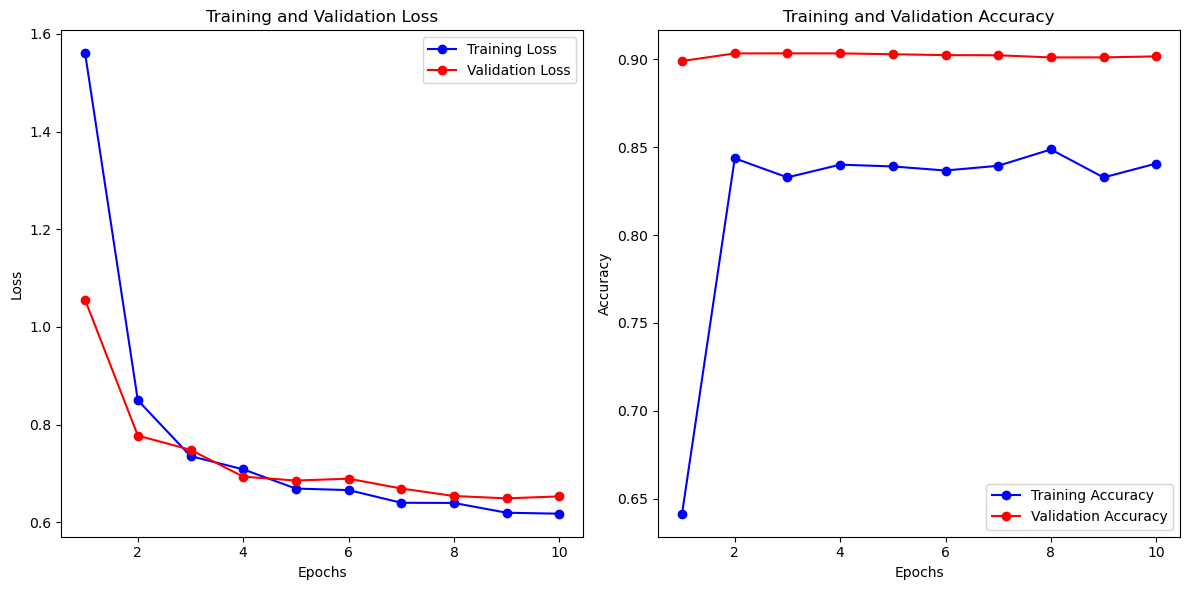

In [48]:
visualize_learning_curves(epochs,train_loss,val_loss,train_accuracy,val_accuracy)

#### Two stage evaluation approach

In [75]:
def plot_predictions(dataset, predictions, num_samples=3):
    """
    Visualizes original images, ground truth masks, and predicted masks.
    
    :param dataset: A tf.data.Dataset object containing (image, mask) pairs.
    :param predictions: A numpy array of predicted masks.
    :param num_samples: Number of samples to visualize.
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    for i, (image, true_mask) in enumerate(dataset.take(num_samples)):
        pred_mask = predictions[i]
        
        # Plot original image
        axes[i, 0].imshow(image.numpy()[0,...,0], cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        # Plot ground truth mask
        axes[i, 1].imshow(true_mask.numpy()[0,...,0], cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        # Plot predicted mask
        axes[i, 2].imshow(pred_mask[0,...,0], cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


The model was saved during training, reconstruction must be made with the weights. Reusing the model of training (same model)

Predictions of heatmaps extraction

In [40]:
pred_model = unet_model

In [42]:
pred_model.load_weights('logs/Linear Interpolation/DATASET_AXIAL/residual_unet3d_2023-11-12-16:42:27/cp.ckpt')

In [44]:
predictions = pred_model.predict(test_axial)

2023-11-13 01:14:14.366892: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-11-13 01:18:46.505932: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-13 01:18:47.312010: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


the class (i.e., the landmark) that has the highest probability at each voxel:

In [65]:
predicted_classes = np.argmax(predictions, axis=-1)

In [86]:
predicted_classes.shape

(48, 30, 320, 320)

In [67]:
class_mapping = landmarkClasses['DATASET_AXIAL']
# Map each index to the corresponding class label
predicted_labels = np.vectorize(class_mapping.get)(predicted_classes)
len(predicted_labels)

48

In [94]:
volume_index = 0  # Index of the volume to visualize
channel_index = 0  # Index of the heatmap channel (landmark) to visualize

In [104]:
mri_volume = []
mask_gt = []
for vol,mask in test_axial.take(1):
    mri_volume = vol.numpy()
    mask_gt = mask.numpy()

In [110]:
mask_gt[0].shape

(30, 320, 320, 12)

In [111]:
mri_volume[0].shape

(30, 320, 320, 1)

In [116]:
mri_vol = mri_volume[volume_index]
mask_gt_vol = mask_gt[volume_index]
heatmaps = predictions[volume_index, ...]
heatmaps.shape

(30, 320, 320, 12)

In [130]:
def visualize_montage_mri_4D_channel(mri_volume,heatmaps_masks,channel, start_slice, end_slice, step=1):
    num_landmarks = heatmaps_masks.shape[-1] 
    
    fig, axarr = plt.subplots(1, (end_slice - start_slice) // step, figsize=(20, 5*num_landmarks))
    
    max_intensity_idx = np.unravel_index(np.argmax(heatmaps_masks[..., channel]), heatmaps_masks[..., channel].shape)
    print(f"Channel {channel} has maximum intensity at slice: {max_intensity_idx[0]}")

    for i, idx in enumerate(range(start_slice, end_slice, step)):
            axarr[i].imshow(mri_volume[idx,:, :], cmap='gray')  # MRI in grayscale
            axarr[i].imshow(heatmaps_masks[idx,:, :, channel], cmap='jet', alpha=0.5)  # specific landmark heatmap overlay
            axarr[i].axis('off')
            if i == 0:
                if channel == num_landmarks - 1:
                    axarr[i].set_ylabel(f'Background')
                else:
                    axarr[i].set_ylabel(f'Landmark {channel + 1}')
                
            axarr[i].set_title(f'Slice: {idx}')
        
    plt.tight_layout()
    plt.show()
    
def visualize_specific_slice_4Dmask(slice_idx,channel,mri_volume, heatmaps_channel):
    fig, axarr = plt.subplots(1, figsize=(16, 8))
    axarr.imshow(mri_volume[:,:,slice_idx],cmap='gray')
    axarr.imshow(heatmaps_channel[:, :, slice_idx, channel], cmap='jet', alpha=0.5)
    axarr.set_title(f'Slice: {slice_idx}')
    plt.show()

Channel 0 has maximum intensity at slice: 0


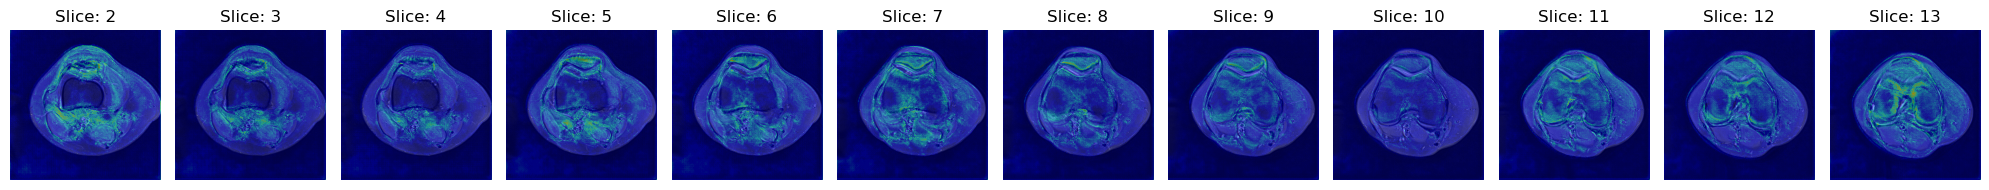

In [131]:
# predicted
visualize_montage_mri_4D_channel(mri_vol,heatmaps,0,2,14,1)

Channel 11 has maximum intensity at slice: 0


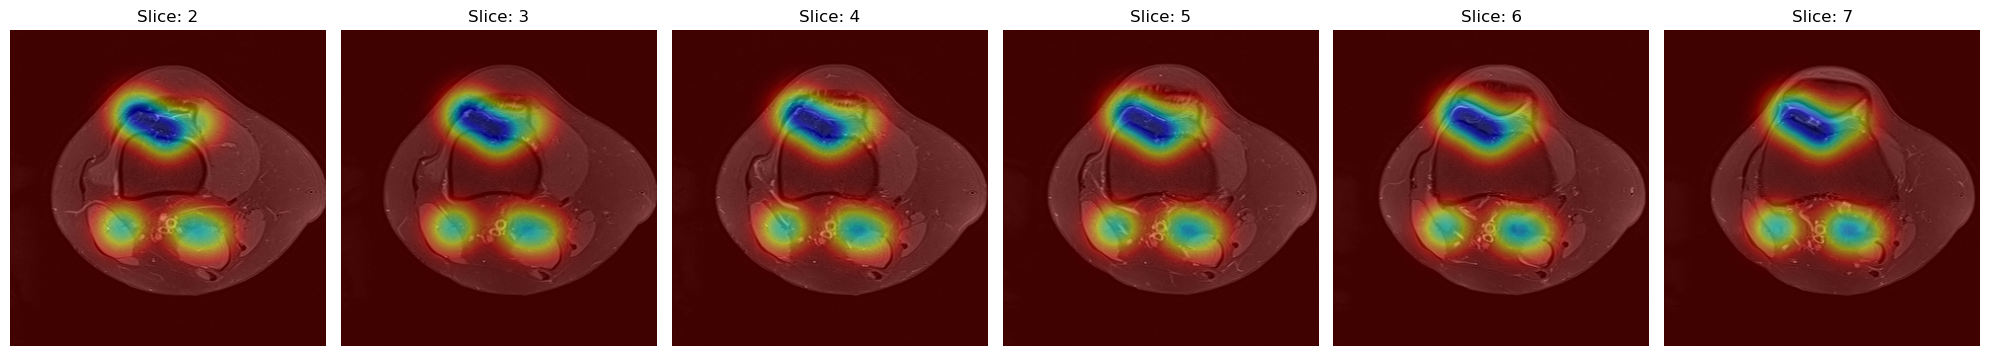

In [134]:
# ground truth
visualize_montage_mri_4D_channel(mri_vol,mask_gt_vol,11,2,8                                                                                                                                                                                                             ,1)

Ground Truth extraction

In [55]:
test_ground_truth = [] # Extract ground truth labels from test_axial
for _, mask in test_axial:
    test_ground_truth.append(mask.numpy())
test_ground_truth = np.array(test_ground_truth)
test_ground_truth_reshaped = test_ground_truth.reshape(-1, *test_ground_truth.shape[2:])

In [70]:
print(test_ground_truth.shape)


(24, 2, 30, 320, 320, 12)
(48, 30, 320, 320)


In [72]:
print("Reshaped Ground Truth Shape:", test_ground_truth_reshaped.shape)
print("Predicted label Shape:",predicted_labels.shape)

Reshaped Ground Truth Shape: (48, 30, 320, 320, 12)
Predicted label Shape: (48, 30, 320, 320)


In [76]:
predictions.shape

(48, 30, 320, 320, 12)

In [77]:
predicted_heatmap_0 = predictions[0]
predicted_landmarks_0 = extract_landmark_positions(predicted_heatmap_0)

In [84]:
predicted_heatmap_0.shape

(30, 320, 320, 12)

##### Stage 2 - Predicted landmarks vs Ground Truth landmarks

In [68]:
def extract_landmark_positions(heatmaps):
    # Assuming heatmaps is a 4D tensor of shape (depth, height, width,  n_heatmaps)
    landmarks = []
    for i in range(heatmaps.shape[-1]):  # Iterate over each heatmap
        heatmap = heatmaps[..., i]
        # Find the index of the maximum value in the heatmap
        idx = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)
        landmarks.append(idx)
    return landmarks

In [69]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

def calculate_distances(predicted_landmarks, ground_truth_landmarks):
    distances = []
    for pred, true in zip(predicted_landmarks, ground_truth_landmarks):
        distances.append(euclidean_distance(pred, true))
    return distances